# Laboratoria #1
## Predykcja przyjęć do szpitala

Zbiór danych pochodzi z systemu amerykańskiego *National Electron Injury Surveillance System*.
Opisuje on przyjęcia do szpitala koszykarzy z urazami. Celem zadania jest predykcja, czy znając szczegółowe informacje na temat pacjenta (takie jak: wiek, rasa, płeć, miejsce urazu, wstępna diagnoza (ustalona w wyniku triażu) oraz rozmiaru placówki.

Problemy, które się pojawią:
- niezbalansowany zbiór danych,
- tuning hiperparametrów,
- feature engineering.

Plik **NEISS.TXT** zawiera zbiór danych, natomiast **NEISS_FMT.TXT** - opis wartości poszczególnych typów zmiennych.
Zadanie polega na zdeterminowaniu, co wpływa na prawdopodobieństwo przyjęcia do szpitala (kolumna *Disposition*)


In [1]:
# Instalacja wymaganych bibliotek
!pip install --upgrade scikit-learn catboost xgboost pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.3 MB/s 
     |████████████████████████████████| 255.9 MB 33 kB/s 
     |████████████████████████████████| 320 kB 8.2 MB/s 
     |████████████████████████████████| 315 kB 41.9 MB/s 
     |████████████████████████████████| 6.8 MB 9.9 MB/s 
     |████████████████████████████████| 17.0 MB 111 kB/s 
     |████████████████████████████████| 167 kB 32.3 MB/s 
     |████████████████████████████████| 88 kB 4.3 MB/s 
     |████████████████████████████████| 636 kB 22.0 MB/s 
     |████████████████████████████████| 56 kB 1.2 MB/s 
     |████████████████████████████████| 1.7 MB 22.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 25.9 MB 1.4 MB/s 
     |████████████████████████████████| 4.

In [1]:
# Import wymaganych bibliotek
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

## Ładowanie danych

Interesujące nas kolumny:

* Age (numerical)
* Sex (categorical)
* Race (categorical)
* Body_Part (categorical): Coded numbers that correspond to body parts
* Diagnosis (categorical): Coded numbers that correspond to diagnostic codes
* Fire_Involvement (categorical): Whether or not a fire was involved with the incident
* Stratum (categorical): The size of the hospital where the individual was seen
* Location (categorical): The location at which the injury took place

Zmienna, którą będziemy przewidywać: "Disposition"

* Szybki kurs dot. biblioteki *pandas*: https://www.kaggle.com/code/residentmario/creating-reading-and-writing

**Pytanie**:
* Które zmienne nie zostały tu uwzględnione? Jak myślisz, dlaczego?


In [2]:
df = pd.read_csv('NEISS.TXT', delimiter='\t')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,...,Fire_Involvement,Alcohol,Drug,Product_1,Product_2,Product_3,Narrative,Stratum,PSU,Weight
0,110100413,01/01/2011,15,1,2,NaN,NaN,79,64,NaN,...,0,NaN,NaN,1205,0,0,15YO MALE HURT GROIN PLAYING BASKETBALLSTRAIN ...,S,98,68.3455
1,110104625,01/01/2011,46,1,0,NaN,NaN,88,59,NaN,...,0,NaN,NaN,1205,0,0,"DX LAC, UPPER LIP: 46YOM LOWER LIP LAC AFTER P...",V,67,16.0885
2,110106682,01/04/2011,14,1,2,NaN,NaN,37,64,NaN,...,0,NaN,NaN,1205,0,0,"14YOM, SPRAIN TO R ANKLE WHILE PLAYING BASKETB...",S,71,68.3455
3,110107736,01/02/2011,14,1,1,NaN,NaN,35,64,NaN,...,0,NaN,NaN,1205,0,0,HURT PLAYING BASKETBALL L KNEE STRAIN 14 YO M #,L,55,62.2225
4,110107744,01/03/2011,14,1,1,NaN,NaN,76,53,NaN,...,0,NaN,NaN,1205,0,0,BASKETBALL INJURY NASAL CONTUSION 14 YO M #$,L,55,62.2225


In [3]:
# DF zawierające wybrane kolumny pod kątem budowy przyszłego modelu
df_smaller = df[['Age', 'Sex', 'Race',
'Body_Part', 'Diagnosis', 'Disposition',
'Fire_Involvement', 'Stratum', 'Location']]
display(df_smaller)

,Age,Sex,Race,Body_Part,Diagnosis,Disposition,Fire_Involvement,Stratum,Location
0,15,1,2,79,64,1,0,S,8
1,46,1,0,88,59,1,0,V,9
2,14,1,2,37,64,1,0,S,8
3,14,1,1,35,64,1,0,L,9
4,14,1,1,76,53,1,0,L,9
...,...,...,...,...,...,...,...,...,...
117105,13,1,2,37,64,1,0,C,0
117106,16,1,1,37,71,1,0,C,0
117107,14,1,2,37,57,1,0,C,0
117108,17,1,2,75,52,1,0,C,8


## Wizualizacja danych

Rzut oka na rozkłady poszczególnych zmiennych.

**Pytania**:
* Przeanalizuj wykresy. Jakie wartości pojawiają się najczęściej dla zaprezentowanych zmiennych?
* Które ze zmiennych moglibyśmy pominąć?


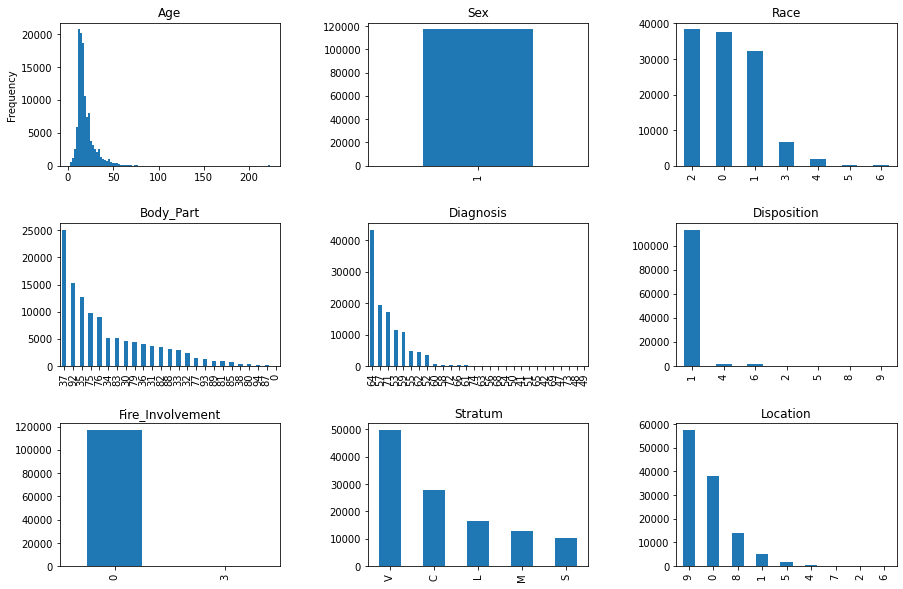

In [4]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, d in enumerate(df_smaller.columns):
  fig.add_subplot(3,3,idx+1)
  if d == 'Age':  # jedynie wiek jest zmienną ciągłą, stąd musimy ją zdyskretyzować
    df[d].plot(kind='hist', bins=100, title=d)
  else:
    df[d].value_counts().plot(kind='bar', title=d)

## Czyszczenie danych

Opis zmiennej *Disposition*:
* DISP	0 - NO INJURY
* DISP	1 - TREATED/EXAMINED AND RELEASED
* DISP	2 - TREATED AND TRANSFERRED
* DISP	4 - TREATED AND ADMITTED/HOSPITALIZED
* DISP	5 - HELD FOR OBSERVATION
* DISP	6 - LEFT WITHOUT BEING SEEN
* DISP	8 - FATALITY INCL. DOA, DIED IN ER
* DISP	9 - UNKNOWN, NOT STATED

In [5]:
# usuwanie wszystkich nieznanych wartości 
df_smaller.loc[df_smaller.Disposition == 9, 'Disposition'] = np.nan
df_smaller['Disposition'] = df_smaller['Disposition'].dropna()

# podział zmiennych na "admit" oraz "notadmint" w zależności od wartości zmiennej
df_smaller.loc[~df_smaller.Disposition.isin([4,5,8]), 'Disposition'] = 'notadmit'
df_smaller.loc[df_smaller.Disposition.isin([4,5,8]), 'Disposition'] = 'admit'
df_smaller['Disposition'].value_counts()

notadmit    115065
admit         2045
Name: Disposition, dtype: int64

Dane są **niezbalansowane**.

**Pytanie**:
* Dlaczego musimy uważać na zbiory danych, które są niezbalansowane? Jakie są sposoby radzenia sobie z takimi zbiorami?

## Kodowanie danych

Modele *machine learning* wymagają danych w postaci numerycznej. Nie wszystkie zmienne ze zbioru danych zawierają dane takiego typu. Dodatkowo, kodowanie liczbami naturalnymi nie jest zawsze dobrym pomysłem, ponieważ algorytmy ML nie wiedzą jaka jest różnica pomiędzy "liczbą" a "kategorią".

Aby algorytm "rozumiał" kategoryczną naturę zmiennych należy wygenerować "one-hot encoding" dla cech tego typu.

Specjalnym przypadkiem są zmienne kategoryczne, gdzie kolejność wartości ma znaczenie, na przykład oceny (1 > 2 > 3, etc.)

Więcej informacji: https://www.youtube.com/watch?v=9yl6-HEY7_s

**Pytania**:
* Które zmienne nie zostały wzięte pod uwagę i dlaczego?
* Czy widzisz jakiś problem, który może się pojawić podczas używania "one-hot encoding"?


In [7]:
categorical_cols = ['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Fire_Involvement', 'Stratum']

df_dummy = pd.get_dummies(df_smaller, columns=categorical_cols)
display(df_dummy)

,Age,Disposition,Location,Sex_1,Race_0,Race_1,Race_2,Race_3,Race_4,Race_5,...,Diagnosis_72,Diagnosis_73,Diagnosis_74,Fire_Involvement_0,Fire_Involvement_3,Stratum_C,Stratum_L,Stratum_M,Stratum_S,Stratum_V
0,15,notadmit,8,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,46,notadmit,9,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,14,notadmit,8,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,14,notadmit,9,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,14,notadmit,9,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117105,13,notadmit,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
117106,16,notadmit,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
117107,14,notadmit,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
117108,17,notadmit,8,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


## ML Pipeline

Pierwszym krokiem jest podział danych na wejściowe (**X**) oraz wyjściowe (**Y**).

In [8]:
X = df_dummy.loc[:, df_dummy.columns != 'Disposition']
Y = df_dummy['Disposition']

In [9]:
# instalacja biblioteki pozwalająca na używanie algorytmów na niezbalansowanych 
# zbiorach danych
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

**Pytania**:

* Jak działa technika *SMOTE*?
* Czym jest metoda *cross-validation* i kiedy jest stosowana?

In [12]:
# podział zbioru danych na treningowy (70%) i testowy (30%)
X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [14]:
# UWAGA: techniki over/under samplingu powinny być używane jedynie na zbiorze treningowym
# aby model mógł być przetestowany na zbiorze o oryginalnym rozkładzie
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train_imbalanced, y_train_imbalanced)

In [15]:
print(Counter(y_train)) # zbiór treningowy został "sztucznie" zbalansowany
print(Counter(y_test)) # zbiór testowy zawiera oryginalny rozkład danych

Counter({'notadmit': 80548, 'admit': 80548})
Counter({'notadmit': 34517, 'admit': 616})


## Klasyfikacja - Drzewo Decyzyjne

In [27]:
from sklearn import tree

scoring = ['accuracy', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'roc_auc']
clf = tree.DecisionTreeClassifier(random_state=42)
scores = cross_validate(clf, X_train, y_train, scoring=scoring, return_estimator=True)
# wybór najlepszego klasyfikatora
best_clf = np.argmax(scores['test_recall_macro'])
clf = scores['estimator'][best_clf]

**Pytania**:

* Opisz metryki użyte podczas trenowania klasyfikatora (*scoring*)

In [22]:
# średnie wyniki 
for k in scores.keys():
  if k != 'estimator':
    print(f"Train {k}: {np.mean(scores[k])}")

Train fit_time: 1.7801636695861816
Train score_time: 0.9999319553375244
Train test_accuracy: 0.9780442471139814
Train test_balanced_accuracy: 0.9780442430541563
Train test_precision_macro: 0.9785236487158929
Train test_recall_macro: 0.9780442430541563
Train test_roc_auc: 0.9875919746624611


## Hiperparametry

Wygląda na to, że Drzewo Decyzyjne poradziło sobie całkiem dobrze. Możemy jednak spróbować znaleźć takie hiperparametry modelu, które zwiększą precyzję modelu. 

In [24]:
# parametry do przeszukania
tree_para = {'criterion':['gini','entropy'], 'max_depth': [1,2,4]}

clf = GridSearchCV(tree.DecisionTreeClassifier(), tree_para, cv=5, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)
clf = clf.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.4s finished


## Ewaluacja modelu

Po tym jak model został wytrenowany, należy sprawdzić jego działanie na zbiorze testowym. Jedną z najpopularniejszych wizualizacji jakości algorytmu klasyfikującego jest **confusion matrix** (*tablica pomyłek*)

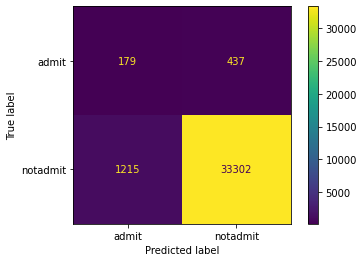

In [28]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, values_format = '')

Mimo iż *accuracy* modelu wyszło wysokie, confusion matrix nie wygląda imponująco. 
**Czułość** (*ang. sensitivity, recall*) jest dość niska: ~ 0.25. **Swoistość** (*ang. specificity*) jest wysoka (~ 95.0), lecz nie możemy ufać algorytmowi, gdyż nie "potrafi" on poprawnie zdecydować czy pacjent powinien zostać przyjęty (błędna klasyfikacja klasy *pozytywnej*).

(Najlepiej wyglądająca macierz posiada najwięcej wartości na przekątnej)

**Pytanie**:
* Opisz różnicę pomiędzy następującymi miarami: *czułość, swoistość, precyzja oraz dokładność*. Zaprezentuj przykład oraz obliczenia.

Skąd ten problem, skoro metryki z *cross-validation* były zachęcające? Jeżeli algorytm uznał, że klasą pozytywną jest "notadmit", wtedy czułość rzeczywiście jest wysoka. W takim przypadku należy zobaczyć raport szczegółowy.


              precision    recall  f1-score   support

       admit       0.13      0.29      0.18       616
    notadmit       0.99      0.96      0.98     34517

    accuracy                           0.95     35133
   macro avg       0.56      0.63      0.58     35133
weighted avg       0.97      0.95      0.96     35133



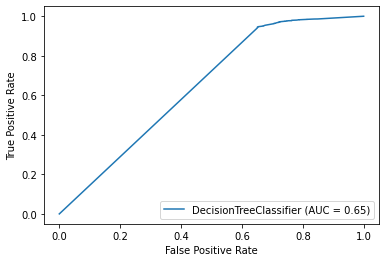

In [29]:
from sklearn.metrics import classification_report, plot_roc_curve

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

plot_roc_curve(clf, X_test, y_test)

Widzimy, że *recall* dla *admit* jest stosunkowo niskie, oraz wartość AUC również jest przeciętna.

**Pytanie**:
* Opisz metryki ROC oraz AUC.


## Inne klasyfikatory

Przetestowaliśmy jeden klasyfikator na naszych danych. Następnym krokiem byłoby wypróbowanie innych algorytmów (może któryś dałby lepsze wyniki?)

Z pomocą przychodzi biblioteka **PyCaret**, która pozwala na automatyczne wykorzystywanie wielu algorytmów. Wymaga on lekko innego przygowania danych.

In [38]:
from pycaret.classification import *

df_smaller['Body_Part'] = df_smaller['Body_Part'].astype('category')
df_smaller['Diagnosis'] = df_smaller['Diagnosis'].astype('category')
df_smaller['Sex'] = df_smaller['Sex'].astype('category')
df_smaller['Race'] = df_smaller['Race'].astype('category')
df_smaller['Fire_Involvement'] = df_smaller['Fire_Involvement'].astype('category')
df_smaller['Stratum'] = df_smaller['Stratum'].astype('category')
df_smaller['Location'] = df_smaller['Location'].astype('category')


# klasa pozytywna
df_smaller.loc[df_smaller.Disposition == 'admit', 'Disposition'] = 1 
# klasa negatywna
df_smaller.loc[df_smaller.Disposition == 'notadmit', 'Disposition'] = 0 

print(Counter(df_smaller['Disposition']))

Counter({0: 115065, 1: 2045})


In [39]:
grid=setup(data=df_smaller, 
           target='Disposition', 
           verbose=True, 
           fix_imbalance=True, 
           bin_numeric_features=['Age'], 
           log_experiment=True, 
           experiment_name='adv1', 
           fold=5)

# Upewnij się, że następujące wartości są poprawne:
# Target = Disposition
# Target Type = Binary
# Label Encoded = 0: 0, 1: 1
# Transformed Train Set = (81976, 101)
# Transformed Test Set = (35134, 101)
# Fold Number = 5
# Fix Imbalance Method = SMOTE

,Description,Value
0,session_id,6464
1,Target,Disposition
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(117110, 9)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:Logging experiment in MLFlow
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='Disposition', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_...
                ('binn', Binning(features_to_discretize=['Age'])),
                ('rem_outliers', 'passthro

In [ ]:
# uruchom uczenie dla wszystkich modeli dostępnych w PyCaret
# n_select mówi ile najlepszeych modeli metoda powinna zwrócić
topmodels = compare_models(n_select = len(models()))

INFO:logs:gpu_param set to False
INFO:logs:Initializing compare_models()
INFO:logs:compare_models(include=None, fold=None, round=4, cross_validation=True, sort=Accuracy, n_select=19, budget_time=None, turbo=True, errors=ignore, fit_kwargs=None, groups=None, experiment_custom_tags=None, probability_threshold=None, verbose=True, display=None, exclude=None)
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Preparing display monitor


IntProgress(value=0, description='Processing: ', max=84)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:03:03
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7973,0.8728,0.8077,0.0644,0.1194,0.0907,0.191,11.966


INFO:logs:Initializing Logistic Regression
INFO:logs:Total runtime is 5.4554144541422525e-05 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lr, fold=StratifiedKFold(n_splits=5, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, experiment_custom_tags=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7f1dfade1fd0>, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Logistic Regression Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=5, random_state=None, sh

Który model jest najlepszy? To zależy także od specyfiki zadania oraz celu, ale najlepiej szukać modelu, który balansuje *accuracy*, AUC oraz *recall* (który jest dla nas najważniejszy).


In [ ]:
# referencje do wybranych modeli 
xgboost = topmodels[3]
lgbm = topmodels[5]
gbm = topmodels[7]
ada = topmodels[8]
lr = topmodels[9]
lda = topmodels[11]

In [ ]:
plot_model(lda, 'auc')
plot_model(lda, 'confusion_matrix')

## Model "blending"

Ostatnim podejściem jest łączenie wielu modeli. Jedną z technik jest "blending"

In [ ]:
# trenowanie klasyfikatora
blender = blend_models(estimator_list=[xgboost, lgbm, gbm, ada, lr, lda], method='auto', fold=5)

In [ ]:
# ewaluacja
predict_model(blender, probability_threshold=0.4)

**Pytanie:**
* Opisz różnice pomiędzy 
Ensemblingiem, Blendingiem oraz Stackingiem modeli 

## Zadanie

Wybierz zbiór danych tabelarycznych i wykonaj następujące kroki:

* opisz zbiór danych, 
* dokonaj eksploracji danych (przedstaw wykresy i przeanalizuj je, co możemy z nich odczytać?),
* oczyść dane (jeżeli jest to konieczne), 
* użyj różnych algorytmów ML, 
* dokonaj ewaluacji modeli (przedstaw ROC, AUC, confusion matrix oraz pozostałe metryki). 

Wykorzystaj różne algorytmy ML, znajdź najlepszy klasyfikator oraz uzasadnij wybór.

Propozycja zbiorów danych: https://github.com/awesomedata/awesome-public-datasets#healthcare

Kroki opisz w sprawozdaniu, załącz plik z danymi oraz link do notebooka Colab. 

**Termin**: do 23:59 dzień przed zajęciami numer 3. Sprawozdanie wraz z danymi należy dodać na platformie e-learning. 